# Neural Network using Conv1d_NN (June 11, 2024)

## I. Setup

In [1]:
# Torch
import torch 
import torch.nn as nn

# MNIST1D
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

# Custom Modules
from NNT import NNT
from Conv1d_NN import Conv1d_NN

torch.Size([32, 1, 120])
torch.Size([32, 1, 120])
torch.Size([32, 32, 40])


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu' # get summary of model

## II. Example Neural Net

In [41]:
# Example Neural Network with Conv1d
model1 = nn.Sequential(
    nn.Conv1d(1, 64, kernel_size=3, stride=1), 
    nn.MaxPool1d(kernel_size=2, stride=2),
    nn.Conv1d(64, 128, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(128*8, 200), 
    nn.ReLU(), 
    nn.Linear(200, 10) 
).to(device)

# Get summary 
from torchsummary import summary
summary(model1, (1, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 38]             256
         MaxPool1d-2               [-1, 64, 19]               0
            Conv1d-3              [-1, 128, 17]          24,704
              ReLU-4              [-1, 128, 17]               0
         MaxPool1d-5               [-1, 128, 8]               0
           Flatten-6                 [-1, 1024]               0
            Linear-7                  [-1, 200]         205,000
              ReLU-8                  [-1, 200]               0
            Linear-9                   [-1, 10]           2,010
Total params: 231,970
Trainable params: 231,970
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.88
Estimated Total Size (MB): 0.96
-------------------------------------------

## MNIST1D Conv model

In [58]:
class ConvBase(nn.Module):
    def __init__(self, output_size, channels=25, linear_in=125):
        super(ConvBase, self).__init__()
        self.conv1 = nn.Conv1d(1, channels, 5, stride=2, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.linear = nn.Linear(linear_in, output_size) # flattened channels -> 10 (assumes input has dim 50)
        print("Initialized ConvBase model with {} parameters".format(self.count_params()))

    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])

    def forward(self, x, verbose=False): # the print statements are for debugging
        x = x.view(-1,1,x.shape[-1])
        h1 = self.conv1(x).relu()
        h2 = self.conv2(h1).relu()
        h3 = self.conv3(h2).relu()
        h3 = h3.view(h3.shape[0], -1) # flatten the conv features
        return self.linear(h3) # a linear classifier goes on top

# def get_model_args(as_dict=False):
#   arg_dict = {'input_size': 40,
#           'output_size': 10,
#           'hidden_size': 256,
#           'learning_rate': 1e-2,
#           'weight_decay': 0,
#           'batch_size': 100,
#           'total_steps': 8000,
#           'print_every': 1000,
#           'eval_every': 250,
#           'checkpoint_every': 1000,
#           'device': 'cpu',
#           'seed': 42}
#   return arg_dict if as_dict else ObjectView(arg_dict)


model2 = ConvBase(10)
# Get summary 
from torchsummary import summary
summary(model2, (1, 40))

Initialized ConvBase model with 5210 parameters
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 25, 19]             150
            Conv1d-2               [-1, 25, 10]           1,900
            Conv1d-3                [-1, 25, 5]           1,900
            Linear-4                   [-1, 10]           1,260
Total params: 5,210
Trainable params: 5,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


## III. Conv1d_NN Neural Net

In [45]:
from NNT import NNT
from Conv1d_NN import Conv1d_NN
# Modified Neural Network with Conv1d
model = nn.Sequential(
    Conv1d_NN(in_channels=1, out_channels =32, K = 3),  # Change the number of input channels to 1
    nn.ReLU(), 
    nn.MaxPool1d(kernel_size=2, stride=2),
    Conv1d_NN(in_channels=32, out_channels=64, K = 3),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(640, 64),  # Change the number of input features to match the output of the last convolutional layer
    nn.ReLU(), 
    nn.Linear(64, 10) 
).to(device)

# Get summary 
from torchsummary import summary
summary(model, (1, 40))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 40]             128
         Conv1d_NN-2               [-1, 32, 40]               0
              ReLU-3               [-1, 32, 40]               0
         MaxPool1d-4               [-1, 32, 20]               0
            Conv1d-5               [-1, 64, 20]           6,208
         Conv1d_NN-6               [-1, 64, 20]               0
              ReLU-7               [-1, 64, 20]               0
         MaxPool1d-8               [-1, 64, 10]               0
           Flatten-9                  [-1, 640]               0
           Linear-10                   [-1, 64]          41,024
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 48,010
Trainable params: 48,010
Non-trainable params: 0
---------------------------------

## IV. Load Data from MNIST1D

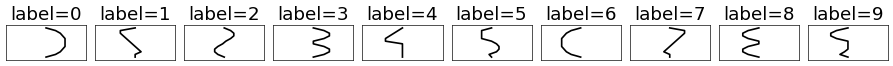

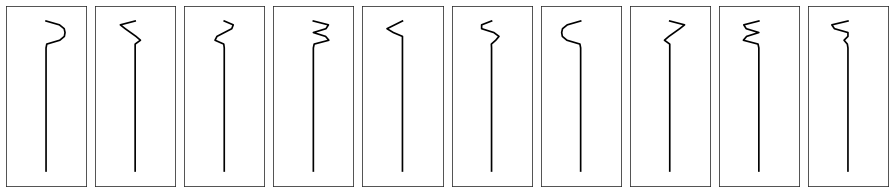

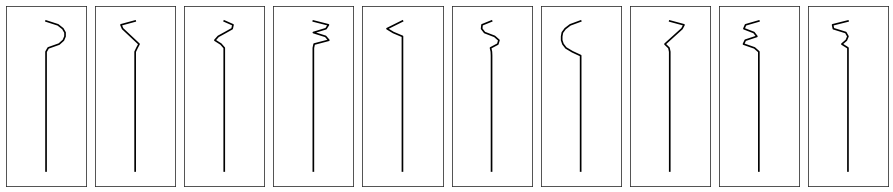

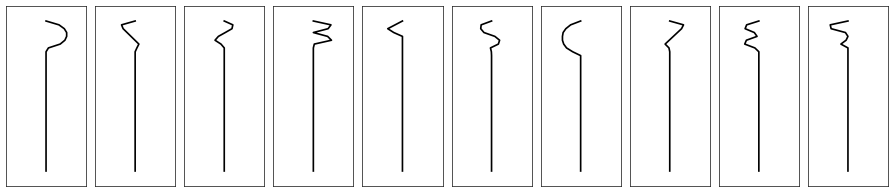

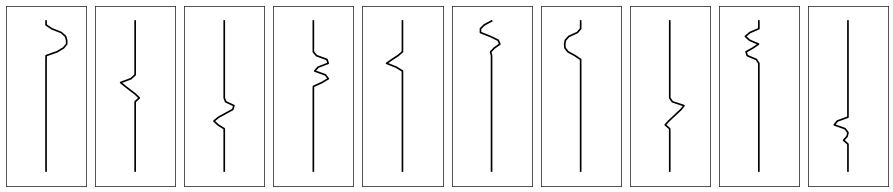

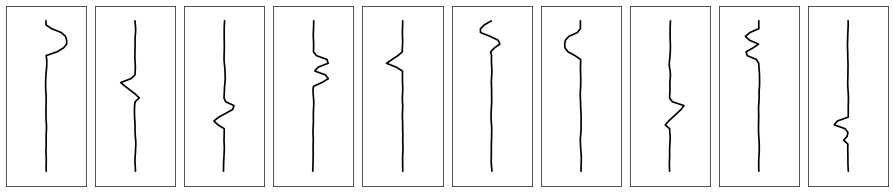

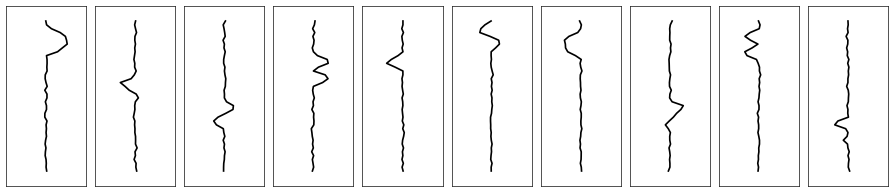

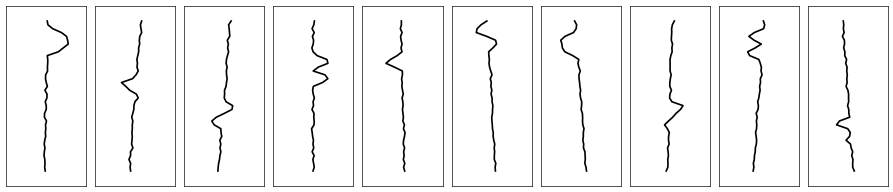

In [26]:
''' Visualization of data '''

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.02,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)

# transformations of the templates which will make them harder to fit
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

# Plotting
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

def apply_ablations(arg_dict, n=7):
    ablations = [('shear_scale', 0),
                ('iid_noise_scale', 0),
                ('corr_noise_scale', 0),
                 ('max_translation', 1),
                 ('scale_coeff', 0),
                 ('padding', [arg_dict['padding'][-1], arg_dict['padding'][-1]]),
                 ('padding', [0, 0]),]
    num_ablations = min(n, len(ablations))
    for i in range(num_ablations):
        k, v = ablations[i]
        arg_dict[k] = v
    return arg_dict

templates = get_templates()
for i, n in enumerate(reversed(range(8))):
    np.random.seed(0)
    arg_dict = get_dataset_args(as_dict=True)
    arg_dict = apply_ablations(arg_dict, n=n)
    args = ObjectView(arg_dict)
    do_transform = args.padding[0] != 0
    fig = plot_signals(templates['x'], templates['t'], labels=None if do_transform else templates['y'],
                 args=args, ratio=2.2 if do_transform else 0.8,
                 do_transform=do_transform)
#     fig.savefig(PROJECT_DIR + 'static/transform_{}.png'.format(i))

In [69]:
from mnist1d.data import make_dataset, get_dataset_args


# Customize dataset 
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)


# Creating Dataset 
defaults = get_dataset_args()

data = make_dataset(defaults) 
x, y, t = torch.Tensor(data['x']), torch.LongTensor(data['y']), torch.tensor(data['t'], dtype=torch.long)
x_test, y_test = torch.Tensor(data['x_test']), torch.LongTensor(data['y_test'])


In [54]:
data['x'].shape

(4000, 40)

In [70]:
print(x.shape, y.shape, t.shape)
print(x_test.shape, y_test.shape)
print(x.dtype, y.dtype, t.dtype)

torch.Size([4000, 40]) torch.Size([4000]) torch.Size([40])
torch.Size([1000, 40]) torch.Size([1000])
torch.float32 torch.int64 torch.int64


In [71]:
# Configure data

from torch.utils.data import Dataset, DataLoader 

class MNIST1DDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = MNIST1DDataset(x, y) 
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MNIST1DDataset(x_test, y_test)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

## V. Train model 


In [72]:
# Configure Training
from torch.optim import Adam 
loss_fn = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=1e-3)

def train_batch(x, y, model, opt, loss_fn): 
    model.train() 
    
    opt.zero_grad()
    batch_loss = loss_fn(model(x), y)
    batch_loss.backward()
    opt.step()
    
    return batch_loss.detach().cpu().numpy()

@torch.no_grad()
def accuracy(x, y, model): 
    model.eval() 
    
    prediction = model(x)
    argmaxes = prediction.argmax(dim=1)
    s = torch.sum(((argmaxes == y).float())/len(y))
    return s.cpu().numpy()



In [73]:
# Training Network 
import numpy as np

losses, accuracies = [], [] 
n_epochs = 100

for epoch in range(n_epochs):
    print(f"Running epoch {epoch+1} of {n_epochs}")
    
    
    epoch_losses, epoch_accuracies = [], []
    
    for batch in train_dl: 
        x, y = batch 
        batch_loss = train_batch(x, y, model2, opt, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.mean(epoch_losses) 
    
    for batch in train_dl: 
        x, y = batch 
        batch_acc = accuracy(x, y, model2)
        epoch_accuracies.append(batch_acc)
    epoch_accuracy = np.mean(epoch_accuracies)
    
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
        

Running epoch 1 of 100
Running epoch 2 of 100
Running epoch 3 of 100
Running epoch 4 of 100
Running epoch 5 of 100
Running epoch 6 of 100
Running epoch 7 of 100
Running epoch 8 of 100
Running epoch 9 of 100
Running epoch 10 of 100
Running epoch 11 of 100
Running epoch 12 of 100
Running epoch 13 of 100
Running epoch 14 of 100
Running epoch 15 of 100
Running epoch 16 of 100
Running epoch 17 of 100
Running epoch 18 of 100
Running epoch 19 of 100
Running epoch 20 of 100
Running epoch 21 of 100
Running epoch 22 of 100
Running epoch 23 of 100
Running epoch 24 of 100
Running epoch 25 of 100
Running epoch 26 of 100
Running epoch 27 of 100
Running epoch 28 of 100
Running epoch 29 of 100
Running epoch 30 of 100
Running epoch 31 of 100
Running epoch 32 of 100
Running epoch 33 of 100
Running epoch 34 of 100
Running epoch 35 of 100
Running epoch 36 of 100
Running epoch 37 of 100
Running epoch 38 of 100
Running epoch 39 of 100
Running epoch 40 of 100
Running epoch 41 of 100
Running epoch 42 of 100
R

In [64]:
print(losses)

[2.3036573, 2.3036575, 2.3036578, 2.3036575, 2.3036575, 2.3036578, 2.3036575, 2.3036575, 2.3036578, 2.3036578, 2.3036575, 2.3036575, 2.3036575, 2.3036575, 2.3036575, 2.3036575, 2.3036575, 2.3036575, 2.3036573, 2.3036575]


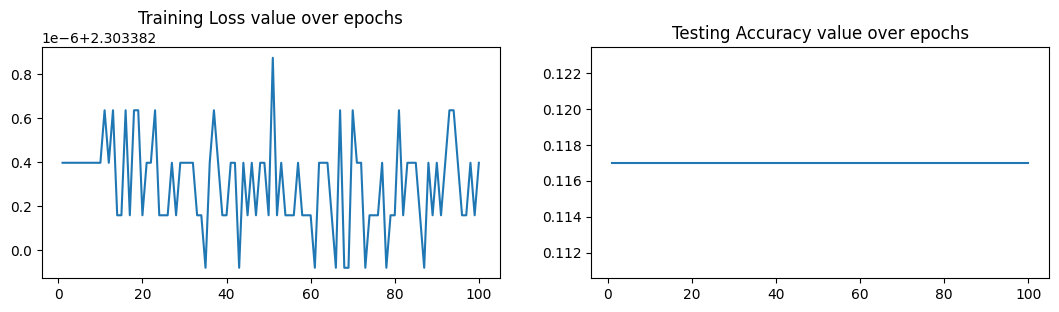

In [74]:
# Visualize how it did during training 
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 3))
plt.subplot(121)
plt.title("Training Loss value over epochs")
plt.plot(np.arange(n_epochs) + 1, losses)
plt.subplot(122)
plt.title("Testing Accuracy value over epochs") 
plt.plot(np.arange(n_epochs) + 1, accuracies)

In [25]:
# Testing the learned classifier 
epoch_accuracies = [] 
for ix, batch in enumerate(iter(test_dl)): 
    x, y = batch 
    batch_acc = accuracy(x, y, model1)
    epoch_accuracies.append(batch_acc)

print(f"Test accuracy: {np.mean(epoch_accuracies):.6f}")
    

Test accuracy: 0.125977


# Neural Network Jan 17 

In [1]:

# Torch
import torch 
import torch.nn as nn

# MNIST1D
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from mnist1d.data import make_dataset, get_dataset_args


# Custom Modules
from NNT import NNT
from Conv1d_NN import Conv1d_NN

from MNIST_1D.models import * 
from MNIST_1D.train import *

device = 'cpu'

In [2]:
# Modified Neural Network with Conv1d
model = nn.Sequential(
    Conv1d_NN(in_channels=1, out_channels =25, K = 3),  # Change the number of input channels to 1
    nn.ReLU(), 
    Conv1d_NN(in_channels=25, out_channels=25, K = 3),
    nn.ReLU(),
    nn.Flatten(), 
    nn.Linear(1000, 10)
).to(device)

# Get summary 
from torchsummary import summary
summary(model, (1, 40))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 25, 40]             100
         Conv1d_NN-2               [-1, 25, 40]               0
              ReLU-3               [-1, 25, 40]               0
            Conv1d-4               [-1, 25, 40]           1,900
         Conv1d_NN-5               [-1, 25, 40]               0
              ReLU-6               [-1, 25, 40]               0
           Flatten-7                 [-1, 1000]               0
            Linear-8                   [-1, 10]          10,010
Total params: 12,010
Trainable params: 12,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.05
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [3]:
model1 = nn.Sequential(
   nn.Conv1d(1, 25, 5, 2, 1), 
   nn.ReLU(),
   nn.Conv1d(25, 25, 3, 2, 1),
   nn.ReLU(),
   nn.Conv1d(25, 25, 3, 2, 1),
   nn.ReLU(),
   nn.Flatten(),
   nn.Linear(125, 10)
)
print(model1.parameters())
# Get summary 
from torchsummary import summary
summary(model1, (1, 40))

<generator object Module.parameters at 0x160d47ca0>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 25, 19]             150
              ReLU-2               [-1, 25, 19]               0
            Conv1d-3               [-1, 25, 10]           1,900
              ReLU-4               [-1, 25, 10]               0
            Conv1d-5                [-1, 25, 5]           1,900
              ReLU-6                [-1, 25, 5]               0
           Flatten-7                  [-1, 125]               0
            Linear-8                   [-1, 10]           1,260
Total params: 5,210
Trainable params: 5,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
-----------------------------------------------------------

In [4]:
model2 = ConvBase(10)

# Get summary
from torchsummary import summary
summary(model2, (4000, 40))

Initialized ConvBase model with 5210 parameters
torch.Size([2, 4000, 40])
torch.Size([8000, 1, 40])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 25, 19]             150
            Conv1d-2               [-1, 25, 10]           1,900
            Conv1d-3                [-1, 25, 5]           1,900
            Linear-4                   [-1, 10]           1,260
Total params: 5,210
Trainable params: 5,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.61
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.64
----------------------------------------------------------------


In [5]:

from mnist1d.data import make_dataset, get_dataset_args

args = get_dataset_args(as_dict=False)


set_seed(args.seed)
args.shuffle_seq = False
data = make_dataset(args = args) # Make the dataset 
data['x'] = torch.Tensor(data['x']).unsqueeze(1)
data['x_test'] = torch.Tensor(data['x_test']).unsqueeze(1)

print(data['x'].shape, data['y'].shape, data['t'].shape)

# set_seed(args.seed)
# args.shuffle_seq = True
# data_shuffle = make_dataset(args = args) # Make the dataset, shuffling the spatial dimension
# data_shuffle['x'] = torch.Tensor(data_shuffle['x']).unsqueeze(1)
# data_shuffle['x_test'] = torch.Tensor(data_shuffle['x_test']).unsqueeze(1)


torch.Size([4000, 1, 40]) (4000,) (40,)


In [3]:

args = get_model_args()
args.device = 'mps'
args.total_steps = 6000

set_seed(args.seed)
results =train_model(data, model1, args)


NameError: name 'data' is not defined

In [6]:
from MNIST_1D.train import *
args = get_model_args()
args.device = 'mps'
args.total_steps = 6000

set_seed(args.seed)
results =train_model(data, model, args)

step 1000, dt 13.55s, train_loss 9.057e-01, test_loss 1.462e+00, train_acc 64.8, test_acc 47.6
step 2000, dt 11.77s, train_loss 7.950e-01, test_loss 1.574e+00, train_acc 71.6, test_acc 47.5
step 3000, dt 11.46s, train_loss 6.646e-01, test_loss 1.821e+00, train_acc 73.5, test_acc 46.9
step 4000, dt 11.50s, train_loss 7.253e-01, test_loss 1.953e+00, train_acc 73.5, test_acc 44.0
step 5000, dt 12.65s, train_loss 6.662e-01, test_loss 1.994e+00, train_acc 74.2, test_acc 46.9
step 6000, dt 12.64s, train_loss 5.036e-01, test_loss 2.092e+00, train_acc 72.9, test_acc 44.9
